# BECHEUR Yazid
------

# PROJET 10
#  <font color="#8333ff">DÉTECTER DES FAUX BILLETS AVEC PYTHON</font>
-------

# CONTEXTE ET OBJECTIF DE LA MISSION : 

L’Organisation nationale de lutte contre le faux-monnayage, ou ONCFM souhaite renforcer ses méthodes d’identification des contrefaçons des billets en euros et pour cela nous confie la mission :
- De mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.
- L’algorithme doit pouvoir différencier les vrais des faux billets à partir des caractéristique géométriques de ces derniers

--------

# PLAN DE TRAVAIL

## I. IMPORTATION DES LIBRAIRIES
      - pandas - numpy - seaborn - matplotlib - scipy - sklearn - statsmodels
      
## II. IMPORTATION DES DONNÉES
      1. DEFFINITION DES VARIABLES
      
## III. EXPLORATION ET NETTOYAGE DES DONNÉES
      1. EXPLORATION DESCRIPTIVES DES VARIABLES
      2. TRAITEMENT DES VALEURS MANQUANTES
           - REGRESSION LINÉAIRE
      
## IV. MODÈLISATION
      1. REGRÉSSION LOGISTIQUE AVEC k-NN
      2. CLUSTERING AVEC k-means
      3. REGRÉSSION LOGISTIQUE AVEC LogisticRegression

## V. CONCLUSION
      - DEPLOIEMENT DU MODÈLE SELECTIONNÉ
------

##  <font color="#8333ff">I. IMPORTATION DES LIBRAIRIES</font>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import t, shapiro
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import neighbors,model_selection
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.metrics import accuracy_score,silhouette_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import decomposition
from sklearn.cluster import KMeans
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from functions import *
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore")

-------
## <font color="#8333ff">II. IMPORTATION DES DONNÉES</font>
------

In [2]:
# Importer le dataset billets
data = pd.read_csv('billets.csv',sep = ';')
billets=data.copy()
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


#### 1. DEFFINITION DES VARIABLES

#### Dimensions géométriques 
Nous disposons actuellement de six informations géométriques sur un
billet :
  - length : la longueur du billet (en mm) ;
  - height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm) ;
  - height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
  - margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) ;
  - margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) ;
  - diagonal : la diagonale du billet (en mm).

In [3]:
data.shape

(1500, 7)

----
## <font color="#8333ff">III. EXPLORATION DES DONNÉES</font>

### Objectif :
- Comprendre du mieux possible nos données 
- Développer une premiere stratégie de modélisation

### Checklist de base
###### Analyse de Forme :
- variable target : is_genuine
- lignes et colonnes : 1500, 7
- types de variables : qualitatives : 1, quantitatives : 6
- Analyse des valeurs manquantes : 37

#### Signification des variables

##### Dimensions géométriques 
Nous disposons actuellement de six informations géométriques sur un
billet :
- length : la longueur du billet (en mm) ;
- height_left : la hauteur du billet (mesurée sur le côté gauche, en
mm) ;
- height_right : la hauteur du billet (mesurée sur le côté droit, en mm) ;
- margin_up : la marge entre le bord supérieur du billet et l'image de
celui-ci (en mm) ;
- margin_low : la marge entre le bord inférieur du billet et l'image de
celui-ci (en mm) ;
- diagonal : la diagonale du billet (en mm).

#### Distribution des variables :

Pour chaque variable les faux billets et les vrais billets présentent respectiveùment une distribution symétrique

#### Relation Variables / Target :

- Le taux de vrais billets est bien nettement plus élevés

### 1. EXPLORATION DESCRIPTIVES DES VARIABLES

In [4]:
# vérifier les valeurs que prend la colonne is_genuine
billets['is_genuine'].unique()

array([ True, False])

In [5]:
# Encoder la variable is_genuine
billets['is_genuine'].replace([False,True], [0,1], inplace=True)
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [6]:
billets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   int64  
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 82.2 KB


In [7]:
# Vérification des valeurs manquantes
billets.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

#### 37 valeurs manquantes pour la variable margin_low 

In [8]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


#### EXPLORATION DE LA DISTRIBUTIONS DES VARIABLES ET LES VALEURS ABERRANTES

<AxesSubplot:ylabel='margin_low'>

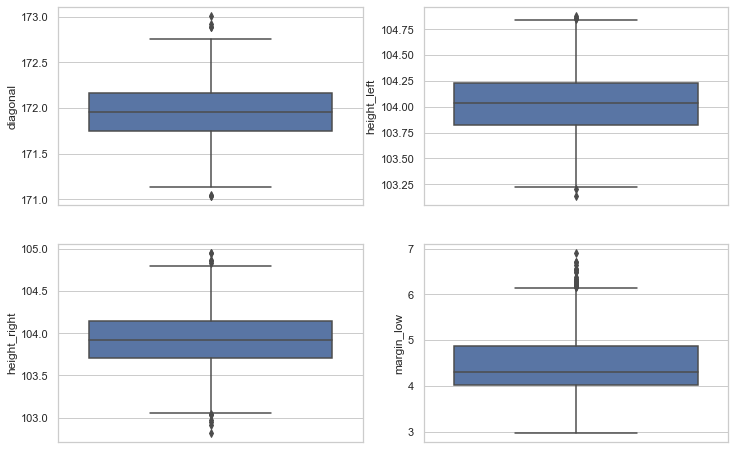

In [9]:
# Afficher des boxplot
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,y='diagonal')
plt.subplot(222)
sns.boxplot(data=billets, y='height_left')
plt.subplot(223)
sns.boxplot(data=billets, y='height_right')
plt.subplot(224)
sns.boxplot(data=billets,y='margin_low')

<AxesSubplot:ylabel='length'>

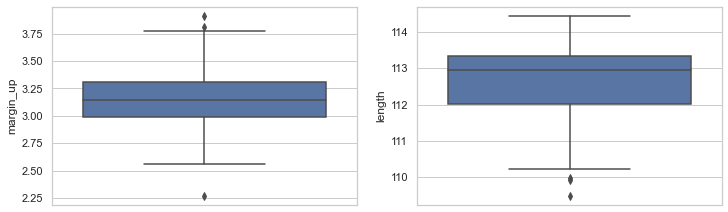

In [10]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')
plt.subplot(222)
sns.boxplot(data=billets,  y='length')

#### LES MOYENNES

In [11]:
# afficher les moyennes de variables
billets.mean()

is_genuine        0.666667
diagonal        171.958440
height_left     104.029533
height_right    103.920307
margin_low        4.485967
margin_up         3.151473
length          112.678500
dtype: float64

#### MATRICES DE CORRÉLATION

In [12]:
# Afficher la matrice de corrélation
corr_df = billets.corr()
h=pd.DataFrame(corr_df)
h.head(10)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,1.000000,0.132756,-0.379833,-0.485092,-0.783032,-0.606262,0.849285
diagonal,0.132756,1.000000,0.019472,-0.024492,-0.111534,-0.055649,0.097587
height_left,-0.379833,0.019472,1.000000,0.242279,0.302643,0.246522,-0.320863
height_right,-0.485092,-0.024492,0.242279,1.000000,0.391085,0.307005,-0.401751
margin_low,-0.783032,-0.111534,0.302643,0.391085,1.000000,0.431606,-0.666753
margin_up,-0.606262,-0.055649,0.246522,0.307005,0.431606,1.000000,-0.520575
length,0.849285,0.097587,-0.320863,-0.401751,-0.666753,-0.520575,1.000000


<AxesSubplot:>

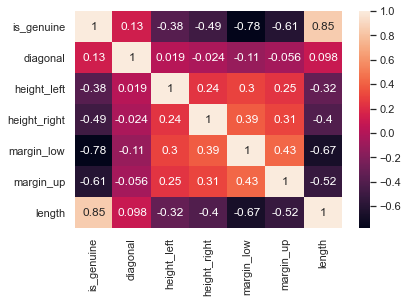

In [13]:
# heatmap de corrélations entre les différentes variables
sns.heatmap(billets.corr(), annot=True)

<Figure size 72x72 with 0 Axes>

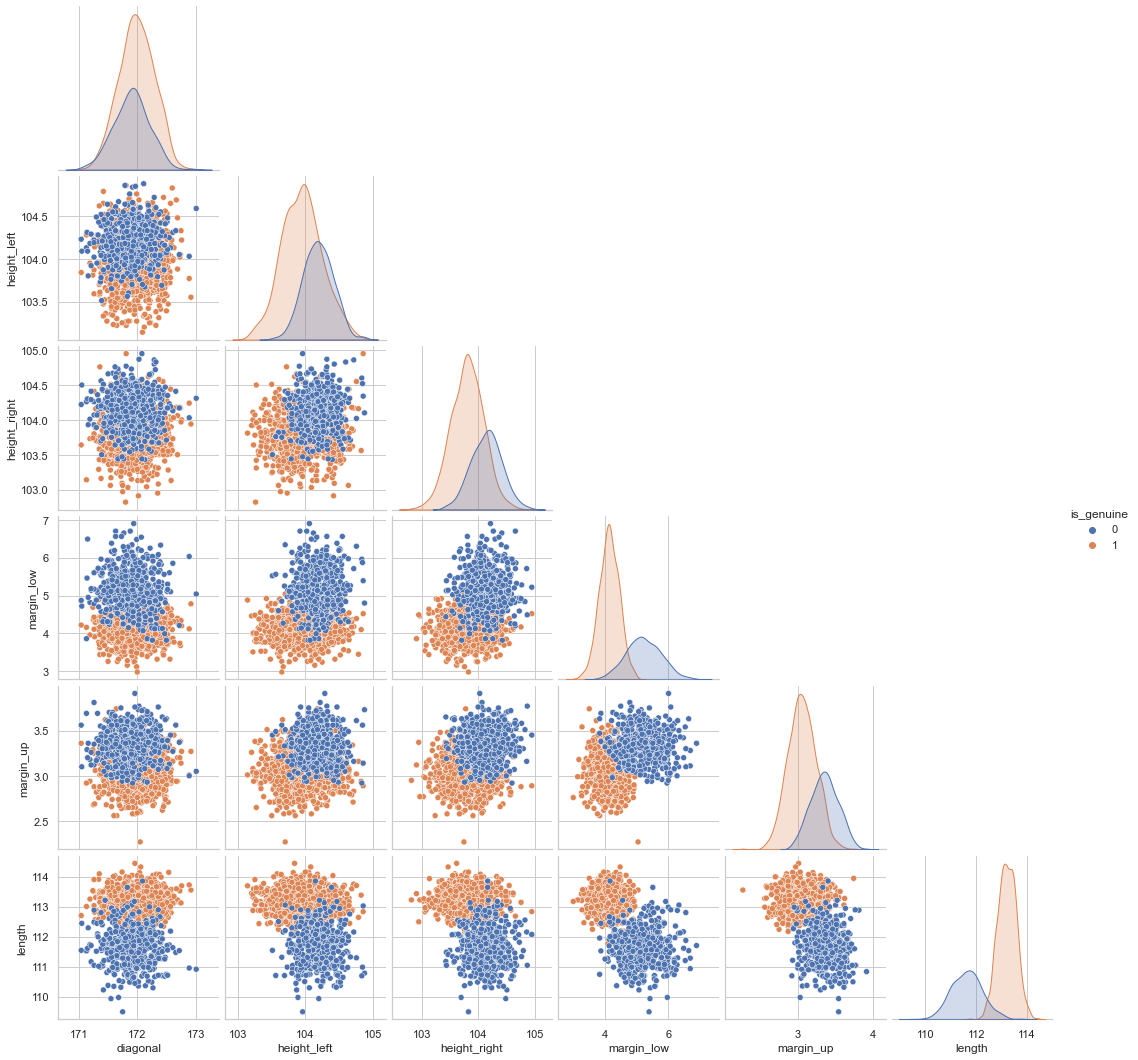

In [14]:
plt.figure(figsize=(1, 1))
sns.pairplot(billets,hue='is_genuine',corner=True)

Text(0.5, 1.0, 'Taux des vrais et faux billets')

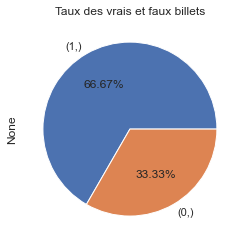

In [15]:
# afficher les taux de faux billets et des vrais billets
billets[['is_genuine']].value_counts().plot.pie(autopct = lambda x: str(round(x, 2)) + '%')
plt.title('Taux des vrais et faux billets')

####  COLINEARITE DES VARIABLES

- Les 2 variables length et margin_up sont corrélées à hauteur de -0.52
- L'une de ces 2 variables devera être écarté de l'analyse pour optimiser le calcul des paramètres

### 2. TRAITEMENT DES VALEURS MANQUANTES
-----

### Utilisation du modèle de régression linéaire multivariables pour traiter nos valeurs manquantes

Nous allons séparer le dataframe original en 2:
- un dataframe sans valeur manquantes que nous utiliserons pour notre régression liniéaire
- un dataframe avec uniquement les valeurs manquantes pour appliquer notre modèle

In [16]:
billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [17]:
# dataset avec les valeurs manquantes
val_manq=billets.loc[billets['margin_low'].isnull(),['is_genuine','diagonal','height_left','height_right','margin_up','length']]
val_manq.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,1,171.94,103.89,103.45,3.25,112.79
99,1,171.93,104.07,104.18,3.14,113.08
151,1,172.07,103.80,104.38,3.02,112.93
197,1,171.45,103.66,103.80,3.62,113.27
241,1,171.83,104.14,104.06,3.02,112.36


### Création du dataframe pour notre analyse


In [18]:
# dataset sans les valeurs manquantes
df1=billets.dropna()
df1.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


## Retirez les variables non significatives

On constate ici que certains paramètres ne sont pas significativement différents de 0, car leur p-valeur n'est pas inférieure à 5 %, le niveau de test que nous souhaitons.

- Le  𝑅2  vaut environ 0.61, et le  𝑅2  ajusté est d'environ 0.61.
- Nous conserverons uniquement les variables dont les paramètres son significatis

In [19]:
columns = ['margin_low','diagonal','is_genuine','height_left','height_right','margin_up','length']
reg_backward = backward_selected(df1[columns], 'margin_low')

_______________________________
margin_low ~ diagonal + length + height_left + is_genuine + margin_up + height_right + 1
remove length (p-value : 0.868 )

_______________________________
margin_low ~ diagonal + height_left + is_genuine + margin_up + height_right + 1
remove diagonal (p-value : 0.719 )

_______________________________
margin_low ~ height_left + is_genuine + margin_up + height_right + 1
remove height_right (p-value : 0.496 )

_______________________________
margin_low ~ height_left + is_genuine + margin_up + 1
remove height_left (p-value : 0.454 )

_______________________________
margin_low ~ is_genuine + margin_up + 1
is the final model !

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                

#### Explorer les valeurs atypiques de la variable margin_up

<AxesSubplot:ylabel='margin_up'>

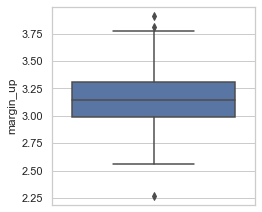

In [20]:
plt.figure(figsize=(8, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=billets,  y='margin_up')

#### Nous supprimons les valeurs atypiques de la variable margin_up

In [21]:
df1=df1.loc[(df1['margin_up']>2.40) & (df1['margin_up']<3.75)]
#df1.sort_values(by = 'margin_up', ascending = False)

### Nous conserverons uniquement les 2 vrariables retenues pour notre analyse

In [22]:
df2= df1.drop(['diagonal','length','height_right','height_left'],axis=1)
# vérification de la supression des valeurs manquantes
df2.head()

,is_genuine,margin_low,margin_up
0,1,4.52,2.89
1,1,3.77,2.99
2,1,4.40,2.94
3,1,3.62,3.01
4,1,4.04,3.48


### Création du modèle sur les 2 variables is_genuine et margin_up

In [23]:
reg_multi = smf.ols('margin_low~+is_genuine+margin_up ', data=df2).fit()
print(reg_multi.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1173.
Date:                Tue, 05 Apr 2022   Prob (F-statistic):          6.00e-304
Time:                        15:48:08   Log-Likelihood:                -765.65
No. Observations:                1456   AIC:                             1537.
Df Residuals:                    1453   BIC:                             1553.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9157      0.200     29.550      0.0

#### Visualiser la distribution de nos erreurs (valeurs absolues)sous forme d'histogramme

 - La quantité d'erreurs suit une loi exponentielle, elle baisse avec l'augmentation de la valeur de l'erreur

In [24]:
x_regr=df2.loc[:,['is_genuine','margin_up']]
ytest=df1['margin_low']

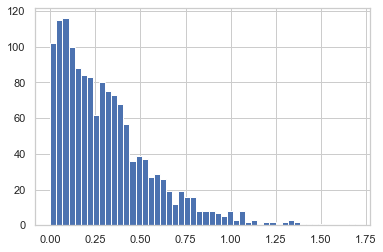

In [25]:
# Représenter nos erreurs avec un histogramme
y_pred=reg_multi.predict(x_regr)
erreur_hi=np.abs(ytest-y_pred)
plt.hist(erreur_hi,bins=50)
plt.show()

### EVALUATION DU MODELE

In [26]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error, median_absolute_error
print("Mean Absolute Error MAE : ", mean_absolute_error(ytest,y_pred ))
print("Erreur Quadratique Moyenne RMSE : ", np.sqrt(mean_squared_error(ytest,y_pred)) )
print("Median Absolute Error : ", median_absolute_error(ytest,y_pred ))
print("Coefficient de Determination R2 : ", r2_score(ytest,y_pred ))

Mean Absolute Error MAE :  0.3146230273938587
Erreur Quadratique Moyenne RMSE :  0.409392054409251
Median Absolute Error :  0.260433739061233
Coefficient de Determination R2 :  0.6175042221015479


### Vérification de la normalité des résidus

In [27]:
# Moyenne des résidus
o=ytest-y_pred
o.mean()

-8.973286094635194e-15

### Si l'on veut tester la normalité des résidus, on peut faire également un test de Shapiro-Wilk.

In [28]:
from scipy import stats
shapiro_test = stats.shapiro(o)
shapiro_test

ShapiroResult(statistic=0.9933310747146606, pvalue=3.882856162817916e-06)

Ici, l'hypothèse de normalité est remise en cause (p-value = 0.0008 < 0.05).

Néanmoins, l'observation des résidus, le fait qu'ils ne soient pas très différents d'une distribution symétrique, et le fait que l'échantillon soit de taille suffisante (supérieure à 30) permettent de dire que les résultats obtenus par le modèle linéaire gaussien ne sont pas absurdes, même si le résidu n'est pas considéré comme étant gaussien.

<AxesSubplot:ylabel='Density'>

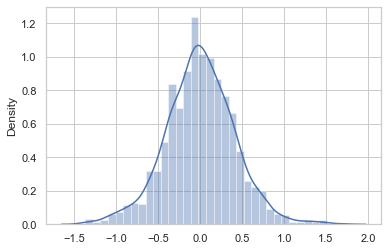

In [29]:
sns.distplot(o)

#### la distribution des résidus est bien symétrique dont la moyenne est proche de 0

### Utilisation de la dorite de HENRY 

Mise en relation les valeurs des résidus (abscisses) avec des valeurs construites sous l'hypothèse que la distribution des résidus est normale.
- Le résultat ci dessous est assez satisfaisant.

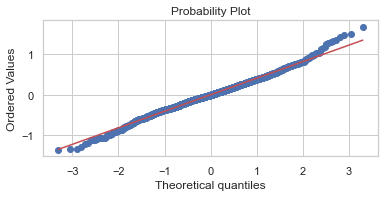

In [30]:
import scipy as sp
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(o, plot=ax, fit=True)

### Normalité des résidus en fonction des valeurs prédites

#### Homoscédasticité

Elle s'observe lorsque la dispersion des residus est homogène ce qui est bien le cas çi-dessous, donc la constance de la variance des résidus, ce qui valide l'hypothèse de linéarité de notre modèle.

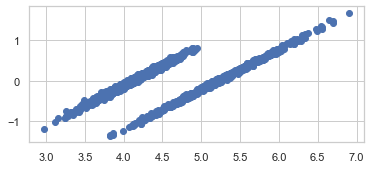

In [31]:
fig, ax = plt.subplots(figsize=(6,2.5))
_= ax.scatter(ytest,o)

## Vérifier la colinéarité des variables

In [32]:
variables = reg_multi.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.5861228832253473, 1.586122883225347]

Ici, tous les coefficients sont inférieurs à 10, il n'y a donc pas de problème de colinéarité.

### Reconstituer le dataframe finale en insérant les valeurs manquantes prédites

In [33]:
# Créer un dataframe san valeurs manquantes et sans la colonne margin_low

val_manq.head()

,is_genuine,diagonal,height_left,height_right,margin_up,length
72,1,171.94,103.89,103.45,3.25,112.79
99,1,171.93,104.07,104.18,3.14,113.08
151,1,172.07,103.80,104.38,3.02,112.93
197,1,171.45,103.66,103.80,3.62,113.27
241,1,171.83,104.14,104.06,3.02,112.36


In [34]:
pred=val_manq.drop(['diagonal','height_left','height_right','length'],axis=1)

val_pred=reg_multi.predict(pred)
val_manq['margin_low_pred']=val_pred

In [35]:
data_final = billets.copy()
data_final.loc[val_manq.index, 'margin_low'] = val_manq['margin_low_pred']
data_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


In [36]:
data_final.shape

(1500, 7)

In [37]:
# vérification des valeurs nulles
data_final.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

### Visualisation de la distribution des différentes variables selon les 2 modalités : vrais et faux billets

Pour étudier le fait d'avoir un vrai ou faux billets en fonction des diférentes variables

La distribution des variables selon les 2 modalités, vrai et faux billet met en évidence les différentes variations 
Ainsi les variables qui semblent le plus impactées :

      - length
      - margin_low
      - margin_up
      - height_right

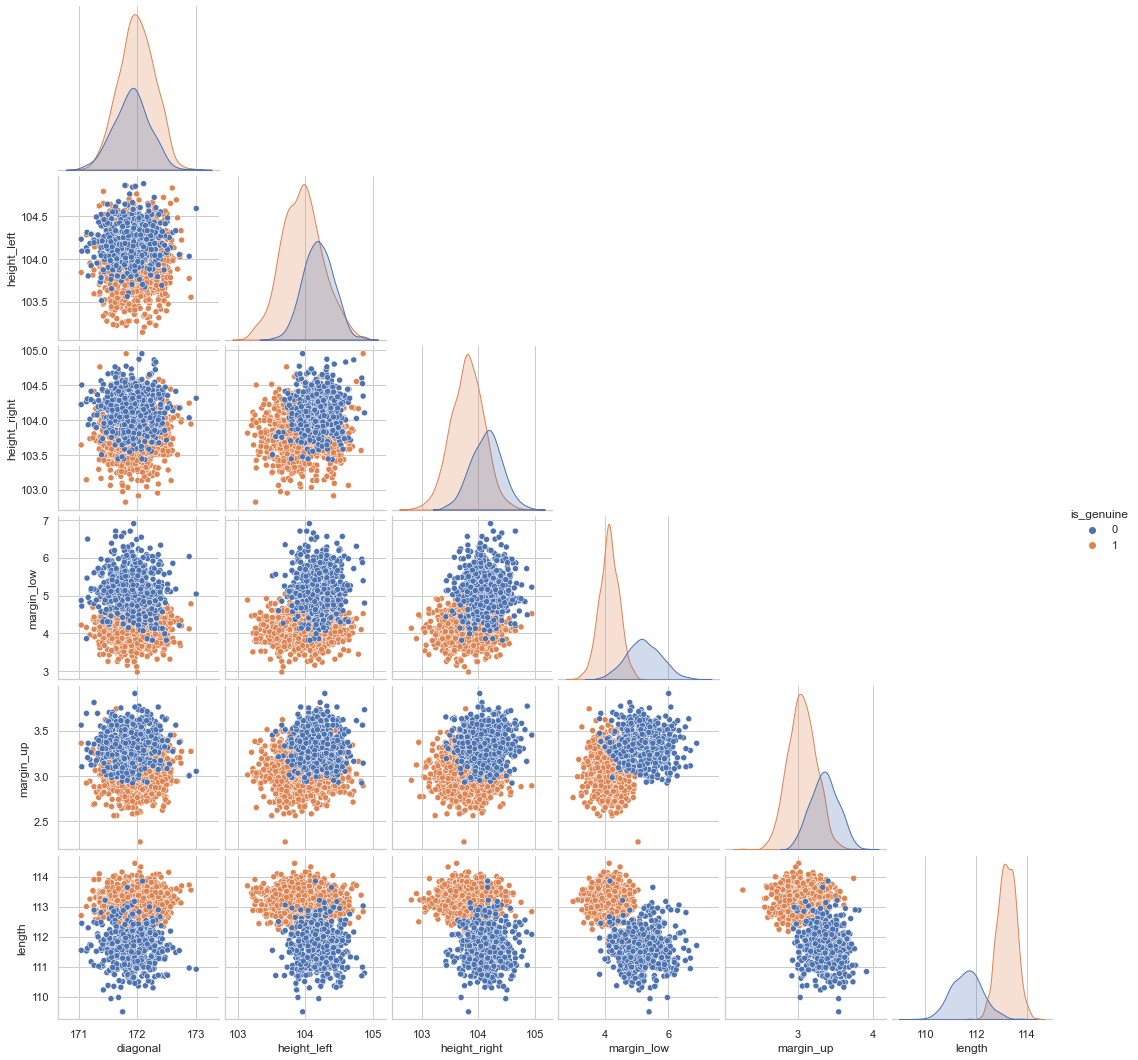

In [38]:
sns.pairplot(data_final,hue='is_genuine',corner=True)
#plt.title('REPREVARIABLES')
plt.savefig('Variables.jpg')
plt.show()

### Analyse de la variance (ANOVA) à 1 facteur
Effectuer une analyse pour mettre en évidence la dépendance entre les 2 modalités(vrai et faux billets) du facteur 'is_genuine' et les variables de notre dataset.
- Afficher la relation du facteur 'is_genuine' et le reste des variables à travers des boites à moustaches
- Cette analyse (ANOVA)est basé sur le test de Fisher

In [39]:
data_final.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,1,171.81,104.86,104.95,4.52,2.89,112.83
1,1,171.46,103.36,103.66,3.77,2.99,113.09
2,1,172.69,104.48,103.50,4.40,2.94,113.16
3,1,171.36,103.91,103.94,3.62,3.01,113.51
4,1,171.73,104.28,103.46,4.04,3.48,112.54


Text(0.5, 1.0, 'Boîtes à moustaches')

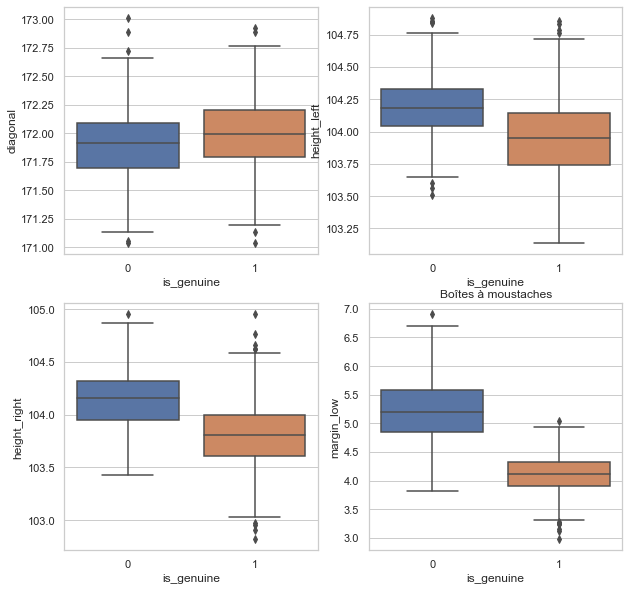

In [40]:
# Afficher des boxplot
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(x="is_genuine", y="diagonal", data=data_final)
plt.subplot(222)
sns.boxplot(x="is_genuine", y="height_left", data=data_final)
plt.subplot(223)
sns.boxplot(x="is_genuine", y="height_right", data=data_final)
plt.subplot(224)
sns.boxplot(x="is_genuine", y="margin_low", data=data_final)
plt.title('Boîtes à moustaches')

<AxesSubplot:xlabel='is_genuine', ylabel='length'>

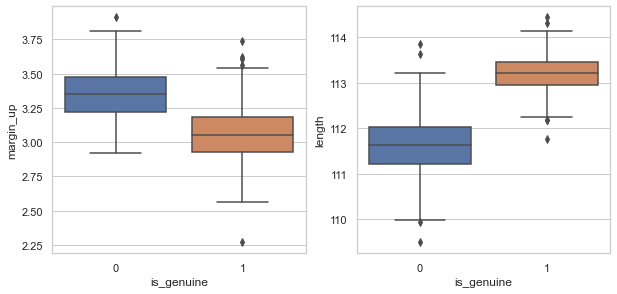

In [41]:
# Afficher des boxplot
plt.figure(figsize=(10, 10))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(x="is_genuine", y="margin_up", data=data_final)
plt.subplot(222)
sns.boxplot(x="is_genuine", y="length", data=data_final)

- Les boites à moustaches indiquent une différence de variances assez nette entre vrais et faux billets concernant chaque variable.
- On constate néanmoins qu'elle est moindre pour la variable 'diagonal'

### Effectuer le test pour vérifier cette observation = dépendances au facteur 'is_genuine'

In [42]:
from IPython.display import display
liste_variable=['diagonal~is_genuine','height_left~is_genuine','height_right~is_genuine','margin_low~is_genuine','margin_up~is_genuine','length~is_genuine']

liste_Df=[]
for a in liste_variable:
    anova_var=smf.ols(a, data=data_final).fit()
    #print(sm.stats.anova_lm(anova_var, typ=2))
    df=pd.DataFrame(sm.stats.anova_lm(anova_var, typ=2))
    display(a,df)
    #print(a,':',df.head(),'\n')
    


'diagonal~is_genuine'

,sum_sq,df,F,PR(>F)
is_genuine,2.460749,1.0,26.874763,2.466867e-07
Residual,137.162201,1498.0,NaN,NaN


'height_left~is_genuine'

,sum_sq,df,F,PR(>F)
is_genuine,19.394088,1.0,252.558393,1.126916e-52
Residual,115.032185,1498.0,NaN,NaN


'height_right~is_genuine'

,sum_sq,df,F,PR(>F)
is_genuine,37.401634,1.0,460.974212,2.270856e-89
Residual,121.541825,1498.0,NaN,NaN


'margin_low~is_genuine'

,sum_sq,df,F,PR(>F)
is_genuine,403.353361,1.0,2423.639486,2.341524e-315
Residual,249.304131,1498.0,NaN,NaN


'margin_up~is_genuine'

,sum_sq,df,F,PR(>F)
is_genuine,29.607294,1.0,870.581394,3.144530e-151
Residual,50.944950,1498.0,NaN,NaN


'length~is_genuine'

,sum_sq,df,F,PR(>F)
is_genuine,823.507935,1.0,3876.654138,0.0
Residual,318.216390,1498.0,NaN,NaN


- La p-valeur de ce test pour toutes les variables est très petite et largement inférieure à 5 %. On rejette donc l'hypothèse H0 selon laquelle  α1=α2=0 .

- Les modalités vrai et faux billets présentent bien un effet sur nos variables

## <font color="#8333ff">IV. MODÈLISATION</font>

#### Vérification des données, l'échelle de grandeur des données n'est pas la même

In [43]:
data_final.describe()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,0.666667,171.958440,104.029533,103.920307,4.482836,3.151473,112.67850
std,0.471562,0.305195,0.299462,0.325627,0.659845,0.231813,0.87273
min,0.000000,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,0.000000,171.750000,103.820000,103.710000,4.027500,2.990000,112.03000
50%,1.000000,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,1.000000,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,1.000000,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


#### Séparons nos données en un jeu d’entraînement et un jeu de test. Le jeu de test contiendra 30% des données.

In [44]:
x2train, x2test, y2train, y2test = train_test_split(data_final.drop(["is_genuine"],axis=1), data_final[["is_genuine"]], test_size=0.2)


#### Nous pouvons maintenant standardiser les données d’entraînement et appliquer la même transformation aux données de test :

In [45]:
std_scale = preprocessing.StandardScaler().fit(x2train)
X_train_std = std_scale.transform(x2train)
X_test_std = std_scale.transform(x2test)

In [46]:
X_train_std.shape

(1200, 6)

## 1. ALGORITHME k-NN (k Nearest Neighbors)

### Rechercher le meilleurs nombre de voisins proches K
Pour trouver le k optimal, on va simplement tester le modèle pour tous les k de 2 à 15, mesurer l’erreur test et afficher la performance en fonction de k

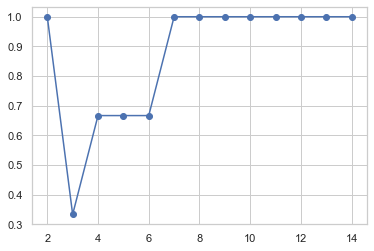

In [47]:
# Optimisation du score sur les données test
errors = []
for k in range(2,15):
    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    #knn.fit(x2train, y2train)
    errors.append(100*(1 - knn.fit(X_train_std,y2train).score(X_test_std,y2test)))
plt.plot(range(2,15), errors, 'o-')
plt.show()

### 2ème Méthode (plus performante)

#### Nous allons maintenant utiliser la méthode "GridSearchCV" pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [48]:
from sklearn import model_selection
# Fixer les valeurs des hyperparamètres à tester
param_grid =  {'n_neighbors': range(2,16) }
# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf1 = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf1.fit(X_train_std, y2train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf1.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf1.cv_results_['mean_test_score'], # score moyen
        clf1.cv_results_['std_test_score'],  # écart-type du score
        clf1.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'n_neighbors': 4}
Résultats de la validation croisée :
accuracy = 0.982 (+/-0.010) for {'n_neighbors': 2}
accuracy = 0.988 (+/-0.011) for {'n_neighbors': 3}
accuracy = 0.993 (+/-0.010) for {'n_neighbors': 4}
accuracy = 0.989 (+/-0.007) for {'n_neighbors': 5}
accuracy = 0.990 (+/-0.008) for {'n_neighbors': 6}
accuracy = 0.991 (+/-0.006) for {'n_neighbors': 7}
accuracy = 0.990 (+/-0.007) for {'n_neighbors': 8}
accuracy = 0.991 (+/-0.006) for {'n_neighbors': 9}
accuracy = 0.993 (+/-0.006) for {'n_neighbors': 10}
accuracy = 0.993 (+/-0.006) for {'n_neighbors': 11}
accuracy = 0.993 (+/-0.006) for {'n_neighbors': 12}
accuracy = 0.993 (+/-0.006) for {'n_neighbors': 13}
accuracy = 0.992 (+/-0.005) for {'n_neighbors': 14}
accuracy = 0.991 (+/-0.008) for {'n_neighbors': 15}


In [49]:
y_pred = clf1.predict(X_test_std)
print("\nSur le jeu de test : {:.3f}".format(clf1.score(X_test_std, y2test)))


Sur le jeu de test : 0.993


### Matrice de confusion

In [50]:
x2test.shape

(300, 6)

In [51]:
# afficher les : vrais négatifs, vrais positifs, fauxnégatifs, faux positifs
tn0, fp0, fn0, tp0 = confusion_matrix(y2test,clf1.predict(X_test_std)).ravel()
tn0, fp0, fn0, tp0
print('Vrais négatifs :',tn0,"\n"'Vrais positifs :',tp0,"\n"'Faux négatifs :',fn0,"\n"'Faux positifs :',fp0)

Vrais négatifs : 113 
Vrais positifs : 185 
Faux négatifs : 1 
Faux positifs : 1


###  <font color="#8333ff">Taux de positifs classés positifs (k-NN)</font>
- La sensibilité = VP / VP+FN

In [52]:
sensibilite0=tp0/(tp0+fn0)
sensibilite0

0.9946236559139785

### <font color="#8333ff">Proportion de prédictions correctes parmi les points que l’on a prédits positifs (Précision)</font>

In [53]:
précision0 = tp0/(tp0+fp0)
précision0

0.9946236559139785

###  <font color="#8333ff">Taux de négatifs classés négatifs (k-NN)</font>
 - La spécificité = VN / FP+VN

In [54]:
specificite0= tn0/(tn0+fp0)
specificite0

0.9912280701754386

 ## 2. ALGORITHME k-means

#### Dans notre étude nous recherchons à partitionner notre jeu de données en 2 clusters distincts (vrai et faux billets)

In [55]:
dfkm=data_final.loc[:,['diagonal','height_left','height_right','margin_low','margin_up','length']]
dfkm.head()

,diagonal,height_left,height_right,margin_low,margin_up,length
0,171.81,104.86,104.95,4.52,2.89,112.83
1,171.46,103.36,103.66,3.77,2.99,113.09
2,172.69,104.48,103.50,4.40,2.94,113.16
3,171.36,103.91,103.94,3.62,3.01,113.51
4,171.73,104.28,103.46,4.04,3.48,112.54


In [56]:
# Selectionner les valeurs à utiliser pour notre analyse
from sklearn import decomposition
X = dfkm.values
#Centrage / réduction des données pour que nos données puissent prendre la même importance
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

### METHODE DU COUDE

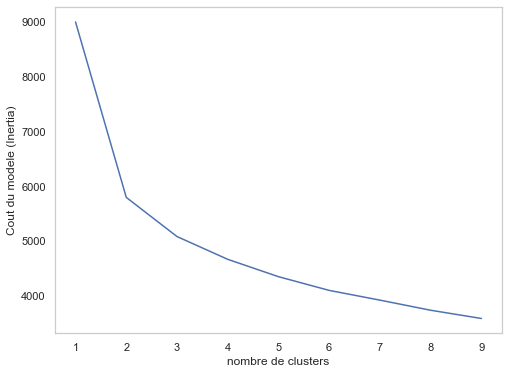

Inertie totale : 3594.078304405085


In [57]:
inertia = []
k_range=range(1,10)
for k in k_range:
    modelkm=KMeans(n_clusters=k).fit(X_scaled)
    inertia.append(modelkm.inertia_)
   
fig = plt.figure(figsize=(8,6))
plt.plot(k_range,inertia )
plt.xlabel('nombre de clusters')
plt.ylabel('Cout du modele (Inertia)')
plt.grid() 
plt.show()
print('Inertie totale :',modelkm.inertia_)

##### <font color="#8333ff">Une zone de coude correspondante à 2 clusters est bien visible</font>

### Application du K-means

In [58]:
from sklearn import cluster, metrics
# Nous déffinissons 2 clusters pour notre modèle et entrainons le sur le jeu d'entrainement
model_km = KMeans(n_clusters=2)
km=model_km.fit(X_scaled)
km.predict(X_scaled)

# évaluer avec le jeu de test
h=km.predict(X_scaled)

# inverser les valeur tel que vrai billet=1 et faux billet=0
a = 1-h
#ypred.inertia_
print('Inertie totale :',km.inertia_)

Inertie totale : 5801.798628796429


#### COEFFICIEN DE SILHOUETTE

In [59]:
silhouette_score(X_scaled,h)

0.3434591797286332

#### Matrice de confusion (k-means)

In [60]:
# taille du jeu de test
a.shape

(1500,)

In [61]:
# afficher les : vrais négatifs, vrais positifs, fauxnégatifs, faux positifs
tn1, fp1, fn1, tp1 = confusion_matrix(data_final['is_genuine'],a).ravel()
tn1, fp1, fn1, tp1
print('Vrais négatifs :',tn1,"\n"'Vrais positifs :',tp1,"\n"'Faux négatifs :',fn1,"\n"'Faux positifs :',fp1)

Vrais négatifs : 14 
Vrais positifs : 10 
Faux négatifs : 990 
Faux positifs : 486


###  <font color="#8333ff">Taux de positifs classés positifs (Sensibilité) (k-means)</font>
- La sensibilité, le taux de positifs classés positifs = VP / VP+FN

In [62]:
sensibilite1=tp1/(tp1+fn1)
sensibilite1

0.01

### <font color="#8333ff">Proportion de prédictions correctes parmi les points que l’on a prédits positifs (Précision)</font>

In [63]:
précision1 = tp1/(tp1+fp1)
précision1

0.020161290322580645

###  <font color="#8333ff">Taux de négatifs classés négatifs (spécificité) (k-means)</font>
 - La spécificité, le taux de négatifs classés négatifs = VN / FP+VN

In [64]:
specificite1= tn1/(tn1+fp1)
specificite1

0.028

### La courbe ROC  (Receiver Operating Characteristic)

Représenter la sensibilité en fonction de la spécificité pour différents seuils de décision s

 - La sensibilité, le taux de positifs classés positifs = VP / VP+FN
 - La spécificité, le taux de négatifs classés négatifs = VN / FP+VN

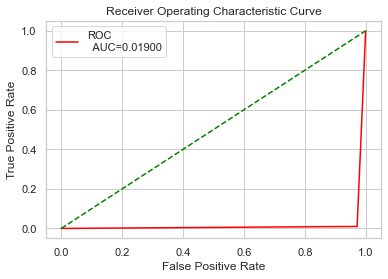

In [65]:
def plot_roc_curve(fp1, tp1):
    aucf =metrics.auc(fp1, tp1)
    plt.plot(fp1, tp1, color='red', label='ROC'+ "\n"'  AUC=%1.5f' % aucf)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = km.predict(X_scaled)
#prob = probs[:, 1]
fp1, tp1, thresholds = roc_curve(data_final['is_genuine'], a)
plot_roc_curve(fp1,tp1 )

## 3.REGRESSION LOGISTIQUE - CLASSIFICATION

### ALGORITHME LogisticRegression


#### Nous allons pour cette régréssion logistique mettre toutes les données à la même échelle (standardisation) pour éviter les biais

#### Réaliser une validation croisée(cross validation) par stratification

In [66]:
# déffinissons le nombre de 5 fractionnements pour notre stratification
skf = StratifiedKFold(n_splits=5)
# désignons notre target
target = data_final[["is_genuine"]]

model3 = LogisticRegression()
# Créons une fonction qui prendra les fractions d'entrainements et de tests
def train_model(train, test, fold_no):
    X = ['diagonal','height_left','height_right','margin_low','margin_up','length']
    y = ['is_genuine']
    X_train = train[X]
    y_train = train[y]
    X_test = test[X]
    y_test = test[y]
    model3.fit(X_train,y_train)
    predictions = model3.predict(X_test)
    print('Fold',str(fold_no),'Accuracy:',accuracy_score(y_test,predictions))
    
# Créons une boucle en utilisant la cross validation ainsi que la fonction créée précédemment,
#pour rappel les données sont standardisées    
fold_no = 1
data_dfm = pd.DataFrame(X_scaled,index=dfkm.index, columns=dfkm.columns)
data_dfm['is_genuine'] =target
for train_index, test_index in skf.split(data_dfm, target):
    train = data_dfm.loc[train_index,:]
    test = data_dfm.loc[test_index,:]
    train_model(train,test,fold_no)
    fold_no += 1

Fold 1 Accuracy: 0.9866666666666667
Fold 2 Accuracy: 0.9866666666666667
Fold 3 Accuracy: 0.9966666666666667
Fold 4 Accuracy: 0.99
Fold 5 Accuracy: 0.9933333333333333


In [67]:
model3.score(X_test_std,y2test)

0.9933333333333333

In [68]:
X_test_std.shape

(300, 6)

### Afficher le dataset final avec le résultat de la prédiction 

In [69]:
tr=data_final.copy()
tr.loc[tr.index, 'prédiction'] = model3.predict(X_scaled)
vr_fau=pd.concat([tr, data_final['is_genuine']], axis=1)
resultat= []
for i in vr_fau['prédiction'] :
    if i == 1 :
        resultat.append('Vrai Billet')
        
    else :
        resultat.append('Faux Billet')

vr_fau['prédiction'] = resultat

vr_fau.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length,prédiction,is_genuine
0,1,171.81,104.86,104.95,4.52,2.89,112.83,Vrai Billet,1
1,1,171.46,103.36,103.66,3.77,2.99,113.09,Vrai Billet,1
2,1,172.69,104.48,103.50,4.40,2.94,113.16,Vrai Billet,1
3,1,171.36,103.91,103.94,3.62,3.01,113.51,Vrai Billet,1
4,1,171.73,104.28,103.46,4.04,3.48,112.54,Vrai Billet,1


#### Vérifier la taille des données 

In [70]:
vr_fau.shape

(1500, 9)

#### Matrice de confusion

In [71]:
# afficher les : vrais négatifs, vrais positifs, faux négatifs, faux positifs
tn, fp, fn, tp = confusion_matrix(data_final['is_genuine'],model3.predict(X_scaled)).ravel()
tn, fp, fn, tp
print('Vrais négatifs :',tn,"\n"'Vrais positifs :',tp,"\n"'Faux négatifs :',fn,"\n"'Faux positifs :',fp)

Vrais négatifs : 491 
Vrais positifs : 998 
Faux négatifs : 2 
Faux positifs : 9


### La courbe ROC  (Receiver Operating Characteristic)

Représenter la sensibilité en fonction de la spécificité pour différents seuils de décision s

 - La sensibilité, le taux de positifs classés positifs = VP / VP+FN
 - La spécificité, le taux de négatifs classés négatifs = VN / FP+VN

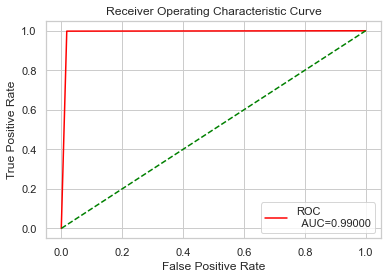

In [72]:
from sklearn import metrics
def plot_roc_curve(fper, tper):
    aucf =metrics.auc(fper, tper)
    plt.plot(fper, tper, color='red', label='ROC'+ "\n"'  AUC=%1.5f' % aucf)
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

prob = model3.predict(X_scaled)
#prob = probs[:, 1]
fper, tper, thresholds = roc_curve(data_final['is_genuine'], prob)
plot_roc_curve(fper,tper )


###  <font color="#8333ff">Taux de positifs classés positifs (Sensibilité-Rappel)</font>

In [73]:
sensibilité=tp/(tp+fn)
sensibilité

0.998

### <font color="#8333ff">Proportion de prédictions correctes parmi les points que l’on a prédits positifs (Précision)</font>

In [74]:
précision = tp/(tp+fp)
précision

0.9910625620655412

###  <font color="#8333ff">Taux de négatifs classés négatifs (Spécificité)</font>

In [75]:
spécificité= tn/(tn+fp)
spécificité

0.982

##  <font color="#8333ff">V. CONCLUSION</font>

Les 2 modèles fournissent une très bonne performance malgré les quelques erreurs:

- L'introduction de  faux billets est le principal critère à prendre en compte, la sélection du modèle se basera donc sur la meilleure précision
- La régression logistique répond parfaitement à cette exigence


## DÉPLOIEMENT DU MODÈLE

###  <font color="#8333ff">ENREGISTRER LE MODÈLE LE PLUS PERFORMANT POUR GÉNÉRALISATION</font>

In [76]:
# enregistrer le modèle
import pickle
pickle.dump(model3, open("model3.pkl", "wb"))


###  <font color="#8333ff">TEST SOUTENANCE</font>

In [77]:
# Charger le dataset
tests=pd.read_csv('billets_production.csv',sep=',')
tests=tests.drop(["id"],axis=1)

# standardisation des données
std_scale = preprocessing.StandardScaler().fit(tests)
X_scaled6 = std_scale.transform(tests)
tests.loc[tests.index,"prédiction"] = model3.predict(X_scaled6)

# Affichage des prédictions
resultat9= []
for i in tests['prédiction'] :
    if i == 1 :
        resultat9.append('Vrai Billet')
        
    else :
        resultat9.append('Faux Billet')

tests['prédiction'] = resultat9

# Afficher le résultat en chiffre
print(tests['prédiction'].value_counts())

tests.head()

Faux Billet    3
Vrai Billet    2
Name: prédiction, dtype: int64


,diagonal,height_left,height_right,margin_low,margin_up,length,prédiction
0,171.76,104.01,103.54,5.21,3.30,111.42,Faux Billet
1,171.87,104.17,104.13,6.00,3.31,112.09,Faux Billet
2,172.00,104.58,104.29,4.99,3.39,111.57,Faux Billet
3,172.49,104.55,104.34,4.44,3.03,113.20,Vrai Billet
4,171.65,103.63,103.56,3.77,3.16,113.33,Vrai Billet
